LOADING THE ELECTRICITY DEMAND DATA

In [58]:
import pandas as pd
import glob
from datetime import timedelta

#path to the drive folder
path = "Demand_data"
#instruction for all files in the folder that end with csv to be appended onto a list using the glob module
all_csv_files = glob.glob(path + "/*.csv")
#creating empty demand list onto which we will add the read csv files as individual lists of files, imagine like in a drawer
demand_list = []

#loop to read through all the filenames that we have created using glob module - those that end with csv
for filename in all_csv_files:
    #reading individual csv file in each cycle
    df = pd.read_csv(filename, index_col=None, header = 0)
    #extract that specific's file first settlement date as the start date - using iloc
    date = pd.to_datetime(df['SETTLEMENT_DATE'].iloc[0])
    #create an empty list onto which we will be appending all the generated timestamps
    timestamps = []
    #for loop to generate the timestamps of corresponding length to the dataframe and in timesteps of 30 minutes then append that data to the timestamps list
    for i in range(0, len(df)*30, 30):
      timestamps.append(date + timedelta(minutes=i))
    #adding the new timestamps lists as an extra column for time identification in the new dataframe
    df['date'] = timestamps
    #appending the new dataframe (with each cycle) into the list of the dataframes
    demand_list.append(df)

#Now concatenate all the lists into one dataframe
df_demand = pd.concat(demand_list, axis = 0, ignore_index=True)

#Filter for only pre-covid demand
df_demand = df_demand[df_demand['date'] < '2020-01-01 00:00:00']
df_demand = df_demand[df_demand['date'] > '2014-12-31 23:30:00']

#Reset the index to identify the split points better later
df_demand = df_demand.reset_index(drop = True)

#Terminal prints to confirm filtered dataframe start and end dates
print(f'First day:', df_demand['date'].iloc[0])
print(f'Last day:', df_demand['date'].iloc[-1])
print(f'dataframe length:', len(df_demand))


#Uncomment to peep into the dataframe
#df_demand

First day: 2015-01-01 00:00:00
Last day: 2019-12-31 23:30:00
dataframe length: 87648


PICKING THE RELEVANT COLUMNS

In [59]:
# List of column names you want to select
columns_to_select = ['date', 'ND']
# Create a new DataFrame with the selected columns
df_demand = df_demand[columns_to_select]
#Creating the time column to be used later
df_demand['time'] =df_demand['date'].dt.time
# Convert the datetime.time object to a string in your desired format
df_demand['time_str'] = df_demand['time'].apply(lambda x: x.strftime('%H:%M:%S'))



#Uncomment to peep into the dataframe
#
#print(len(df_demand))
df_demand

,date,ND,time,time_str
0,2015-01-01 00:00:00,28726,00:00:00,00:00:00
1,2015-01-01 00:30:00,29391,00:30:00,00:30:00
2,2015-01-01 01:00:00,29231,01:00:00,01:00:00
3,2015-01-01 01:30:00,28095,01:30:00,01:30:00
4,2015-01-01 02:00:00,26896,02:00:00,02:00:00
...,...,...,...,...
87643,2019-12-31 21:30:00,29318,21:30:00,21:30:00
87644,2019-12-31 22:00:00,28260,22:00:00,22:00:00
87645,2019-12-31 22:30:00,27530,22:30:00,22:30:00
87646,2019-12-31 23:00:00,26765,23:00:00,23:00:00


Mapping the date to the corresponding days of the week (including the ones that are holidays)

In [60]:
# Extract the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
df_demand['day'] = df_demand['date'].dt.dayofweek

# Define a dictionary to map day of the week to corresponding names
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Map the day of the week to day names
df_demand['day'] = df_demand['day'].map(day_names)
uk_bank_holidays = [
    '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
    '2015-04-03', '2016-03-25', '2017-04-14', '2018-03-30',
    '2015-04-06', '2016-03-28', '2017-04-17', '2018-04-02',
    '2015-05-04', '2016-05-02', '2017-05-01', '2018-05-07',
    '2015-05-25', '2016-05-30', '2017-05-29', '2018-05-28',
    '2015-08-31', '2016-08-29', '2017-08-28', '2018-08-27',
    '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25',
    '2015-12-26', '2016-12-26', '2017-12-26', '2018-12-26'
]

df_demand.loc[df_demand['date'].dt.strftime('%Y-%m-%d').isin(uk_bank_holidays), 'day'] = 'Holiday'
df_demand

,date,ND,time,time_str,day
0,2015-01-01 00:00:00,28726,00:00:00,00:00:00,Holiday
1,2015-01-01 00:30:00,29391,00:30:00,00:30:00,Holiday
2,2015-01-01 01:00:00,29231,01:00:00,01:00:00,Holiday
3,2015-01-01 01:30:00,28095,01:30:00,01:30:00,Holiday
4,2015-01-01 02:00:00,26896,02:00:00,02:00:00,Holiday
...,...,...,...,...,...
87643,2019-12-31 21:30:00,29318,21:30:00,21:30:00,Tuesday
87644,2019-12-31 22:00:00,28260,22:00:00,22:00:00,Tuesday
87645,2019-12-31 22:30:00,27530,22:30:00,22:30:00,Tuesday
87646,2019-12-31 23:00:00,26765,23:00:00,23:00:00,Tuesday


Filtering to get the averages for each day and appending this to a new dataframe

In [61]:
# Filter rows where 'day' column is equal to 'Thursday'
days = ['Holiday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#Creating the empty dataframe
result_df = pd.DataFrame() 

#Extracting time elements from the 
result_df['time'] = df_demand['time_str'][0:48]
result_df


for day in days:
    day_frame = df_demand[df_demand['day'] == day]

    #Exxtracting time from the datetime column and saving it to a new column
    day_frame['time'] = day_frame['date'].dt.time

    # Group by 'day_type' and calculate the sum of demand
    grouped = day_frame.groupby('time')['ND'].mean().reset_index()

    #Renaming the column with the right name
    grouped = grouped.rename(columns={'ND': day})

    #Converting to GW
    grouped[day] = grouped[day]/1000

    # # Merge the grouped DataFrame back into the original DataFrame
    # df_demand = df_demand.merge(grouped, on='time', how='left')
    
    #Appending that to the empty dataframe
    result_df = pd.concat([result_df, grouped[day]], axis=1)

result_df

C:\Users\User\AppData\Local\Temp\ipykernel_544\4291608866.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_frame['time'] = day_frame['date'].dt.time
C:\Users\User\AppData\Local\Temp\ipykernel_544\4291608866.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_frame['time'] = day_frame['date'].dt.time
C:\Users\User\AppData\Local\Temp\ipykernel_544\4291608866.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,time,Holiday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,00:00:00,23.397636,23.231983,24.478721,24.560830,24.661504,24.769122,24.333365,23.662019
1,00:30:00,23.660455,23.419702,24.600833,24.676548,24.762004,24.847671,24.321992,23.647676
2,01:00:00,23.378545,23.224669,24.337415,24.394019,24.473242,24.537290,23.897196,23.231394
3,01:30:00,22.760939,22.803079,23.895345,23.932290,24.007862,24.054063,23.301788,22.633050
4,02:00:00,22.236182,22.493653,23.554465,23.592780,23.654312,23.678631,22.839746,22.163127
5,02:30:00,21.909667,22.380669,23.420081,23.462317,23.511985,23.530318,22.608119,21.918587
6,03:00:00,21.494394,22.227202,23.231512,23.273340,23.315573,23.314494,22.291865,21.575042
7,03:30:00,21.113727,22.067388,23.059969,23.092104,23.133950,23.116957,21.927896,21.185703
8,04:00:00,21.007242,22.343174,23.304516,23.334537,23.364215,23.326824,21.846115,20.998637
9,04:30:00,21.078424,22.985248,23.921930,23.945344,23.965538,23.894855,21.949112,20.939826


Now generating the line plot

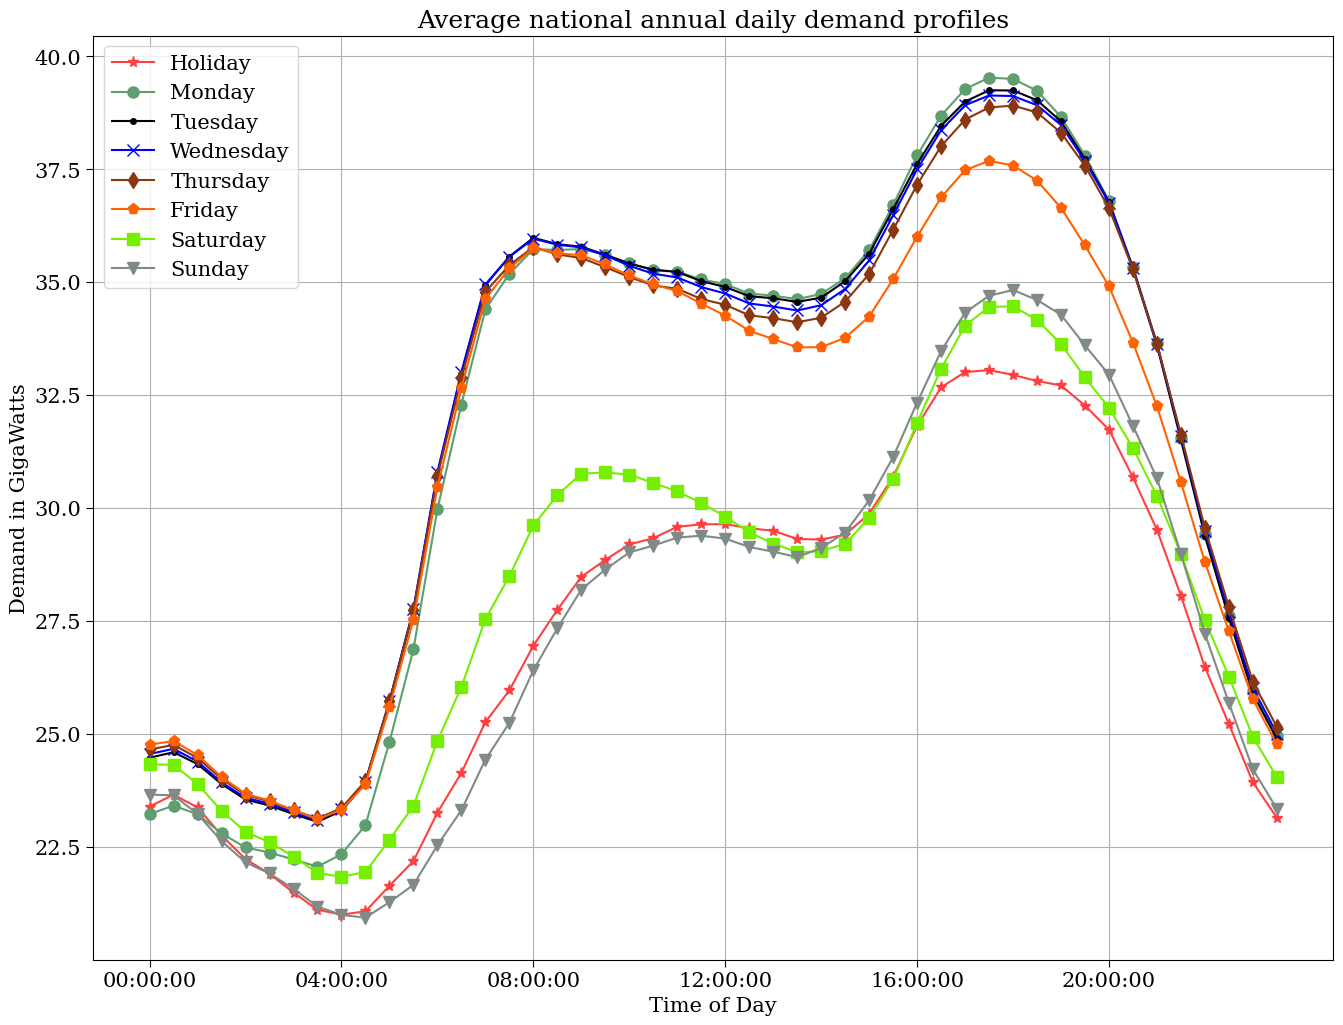

In [64]:
from matplotlib import pyplot as plt
colors = ['#FF4040', '#5f9e6e', '#000000', '#0000FF', '#8A360F', '#FF6103', '#76EE00', '#808A87']
markers = ['*','o','.','x','d','p', 's', 'v']

plt.rcParams.update(
    {
        "lines.markersize": 8,  # Big points
        "font.size": 15,  # Larger font
        "font.family": 'serif',
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

fig, ax = plt.subplots(figsize = (16,12))
for index, day in enumerate(days):
    ax.plot(result_df['time'], result_df[day], color = colors[index], marker = markers[index], label = day)

ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand in GigaWatts')
tick_positions = range(0, len(result_df['time']), 8)
tick_labels = [result_df['time'][i] for i in tick_positions]
# Set the x-tick positions and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_title('Average national annual daily demand profiles')
ax.grid()
ax.legend(loc = 'best')

In [63]:
my_list = ['apple', 'banana', 'cherry']

for index, item in enumerate(my_list):
    print(f'Index {index}: {item}')


Index 0: apple
Index 1: banana
Index 2: cherry
